In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

In [17]:
# Load and prepare data
data = pd.read_csv('production_overshoot.csv')

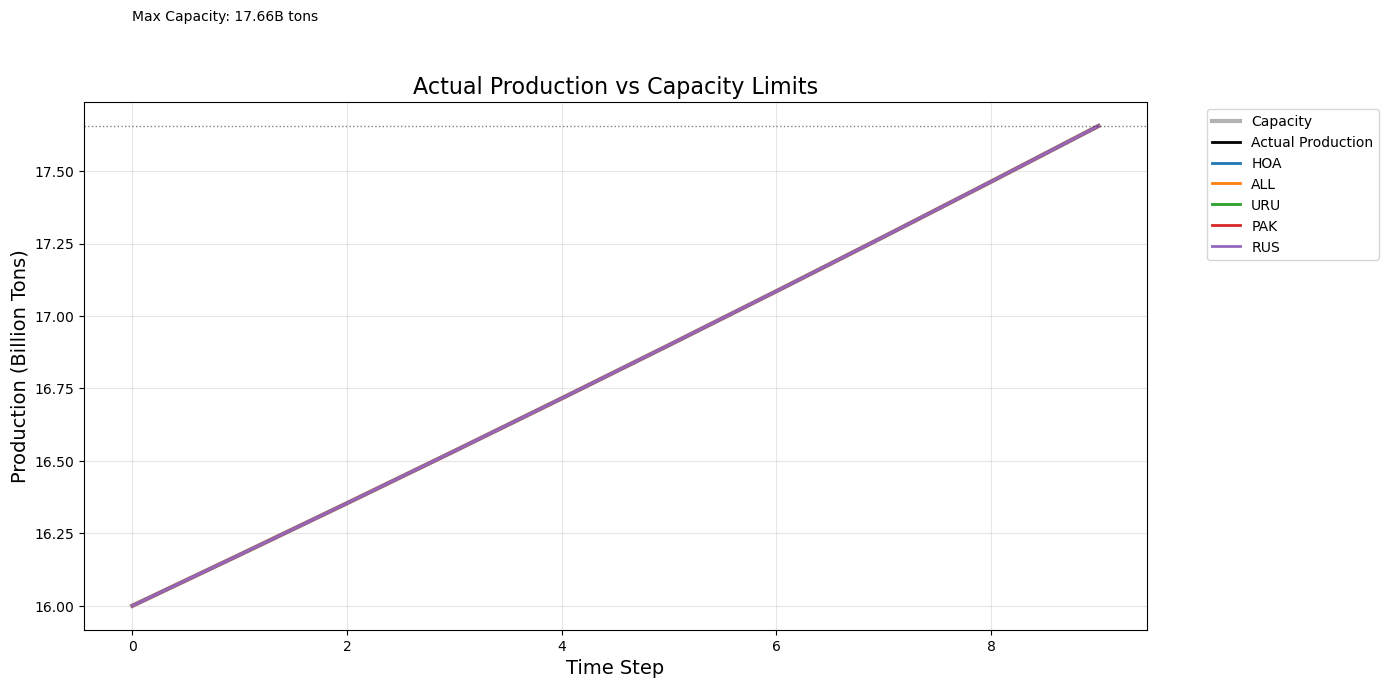


Total Production, Actual Production, and Max Capacity by Scenario (in Billion Tons):
          total_prod  actual_prod    cap
scenario                                
ALL           168.16       168.16  17.66
HOA           168.16       168.16  17.66
PAK           168.16       168.16  17.66
RUS           168.16       168.16  17.66
URU           168.16       168.16  17.66

Average Capacity Utilization (%):
scenario
ALL    100.0
HOA    100.0
PAK    100.0
RUS    100.0
URU    100.0


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Load and prepare data
data = pd.read_csv('production_overshoot.csv')
data['scenario'] = data['scenario'].astype(str).str.strip()

# Check scenarios
print("Scenarios:", data['scenario'].unique())

# Calculate basic actual production (bounded by cap per time step)
data['actual_prod'] = np.minimum(data['total_prod'], data['cap'])

# Calculate per-scenario scaling factor over all time steps
scaling_factors = data.groupby('scenario').apply(
    lambda df: df['cap'].max() / df['total_prod'].sum()
).rename('scaling')

# Merge back scaling into original data
data = data.merge(scaling_factors, on='scenario')

# Apply scaling to get actual scaled production
data['actual_scaled_prod'] = data['total_prod'] * data['scaling']

# Plotting
plt.figure(figsize=(14, 7))
scenarios = data['scenario'].unique()
colors = plt.cm.tab10.colors

for i, scenario in enumerate(scenarios):
    scenario_data = data[data['scenario'] == scenario]
    
    # Plot original total production
    plt.plot(scenario_data['time_step'], scenario_data['total_prod'] / 1e9,
             color=colors[i % len(colors)], linestyle='--', linewidth=1,
             label=f'{scenario} Total')

    # Plot scaled production (adjusted to stay under cap)
    plt.plot(scenario_data['time_step'], scenario_data['actual_scaled_prod'] / 1e9,
             color=colors[i % len(colors)], linestyle='-', linewidth=2,
             label=f'{scenario} Scaled')

    # Plot cap
    plt.plot(scenario_data['time_step'], scenario_data['cap'] / 1e9,
             color=colors[i % len(colors)], linestyle=':', linewidth=2, alpha=0.3,
             label=f'{scenario} Cap')

# Formatting
plt.title('Production vs Capacity (Scaled to Cap)', fontsize=16)
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Production (Billion Tons)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('scaled_production_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary Table
summary = data.groupby('scenario').agg({
    'total_prod': 'sum',
    'actual_scaled_prod': 'sum',
    'cap': 'max'
}) / 1e9  # Convert to billion tons

summary = summary.rename(columns={
    'total_prod': 'Total Prod (raw)',
    'actual_scaled_prod': 'Total Prod (scaled)',
    'cap': 'Max Cap'
})

print("\nProduction Summary by Scenario (in Billion Tons):")
print(summary.round(2).to_string())